# Adaptive Batch Size

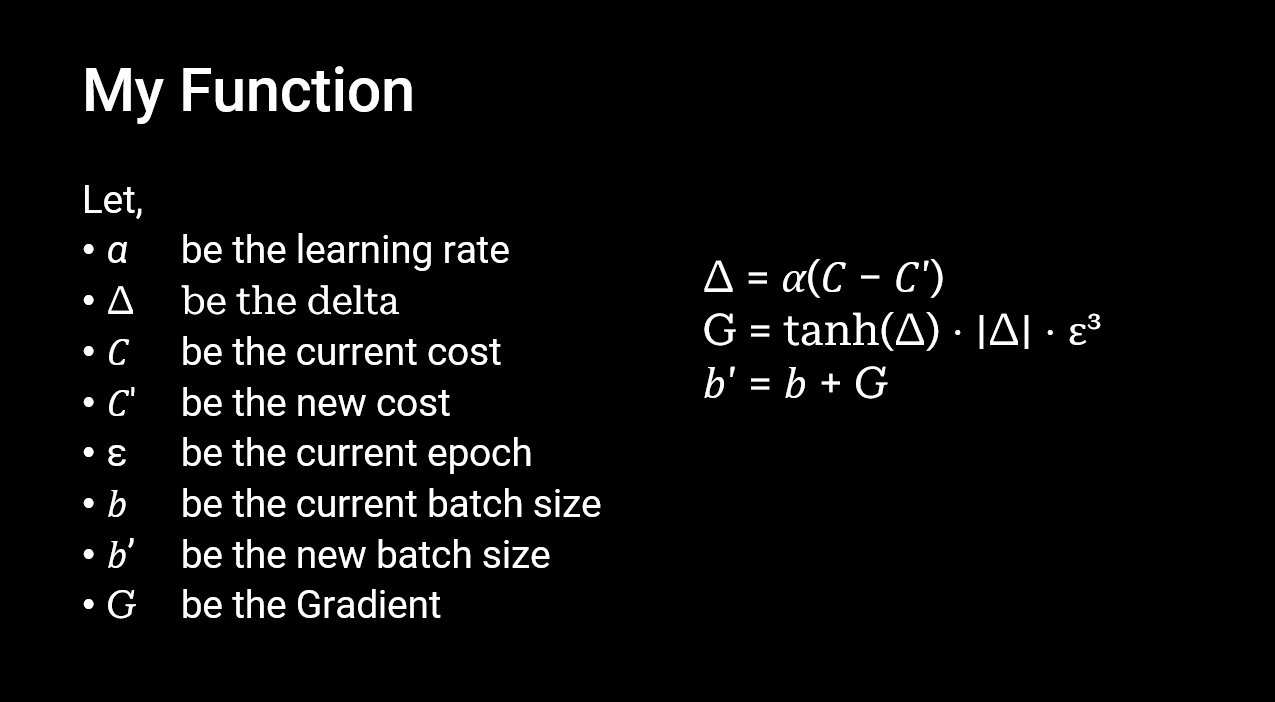

## Imports

In [1]:
from random import randint
from time import time as t

import numpy as np
import plotly.express as px
import plotly.io as pio
import pywt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Conv2D, Dense, Flatten, Input, InputLayer,
                                     Layer)
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

pio.templates.default = 'plotly_dark'

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [3]:
class Timer:
    def __enter__(self):
        self.start = t()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.end = t()
        self.elapsed = self.end - self.start

## Wavelet Class

In [4]:
class WaveletTransformLayer(Layer):
    def __init__(self, wavelet='db1', **kwargs):
        super(WaveletTransformLayer, self).__init__(**kwargs)
        self.wavelet = wavelet

    def build(self, input_shape):
        super(WaveletTransformLayer, self).build(input_shape)

    def call(self, inputs):
        def py_wavelet_transform(image):
            coeffs2 = pywt.dwt2(image.numpy(), self.wavelet)
            LL, (LH, HL, HH) = coeffs2
            return np.stack([LL, LH, HL, HH], axis=-1)

        transformed = tf.py_function(py_wavelet_transform, [inputs], tf.float32)
        
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        height = input_shape[1] // 2
        width = input_shape[2] // 2

        transformed = tf.reshape(transformed, (batch_size, height, width, 4))
        return transformed

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]//2, input_shape[2]//2, 4)

In [73]:
@tf.function
def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

### Layers

In [74]:
input_tensor = Input(shape=(28, 28, 2))
wavelet_layer = WaveletTransformLayer()(input_tensor)
conv_layer = Conv2D(32, kernel_size=(3, 3), activation='relu')(wavelet_layer)
flatten_layer = Flatten()(conv_layer)
dense_layer = Dense(128, activation='relu')(flatten_layer)
output_layer = Dense(10, activation='softmax')(dense_layer)
model = Model(inputs=input_tensor, outputs=output_layer)

## Gradient

In [60]:
def optimize_batch(cost, new_cost, batch_size, epoch, learning_rate=1, min_batch_size=256, max_batch_size=2048):
    if batch_size:
        delta = learning_rate*(cost-new_cost)
        gradient = np.tanh(delta)*np.abs(delta)*(epoch**3)
        print(f'Grad: {gradient}, Delta = {delta}')
        new_batch_size = batch_size + gradient
        
    else:
        new_batch_size = randint(min_batch_size*2, max_batch_size-min_batch_size*2) 
    
    new_batch_size = int(max(min_batch_size, min(max_batch_size, new_batch_size)))
    print(f'Batch Size: {new_batch_size}')
    
    return new_batch_size

In [61]:
batches = []
costs = []
def train_model(model, x_train, y_train, epochs=10):
    loss_object = SparseCategoricalCrossentropy()
    optimizer = Adam()
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = SparseCategoricalAccuracy(name='train_accuracy')
    model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    cost = float('inf')
    new_cost = 0
    batch_size = 0
    for epoch in range(epochs):
        with Timer() as timer:
            print(f'Epoch {epoch + 1}/{epochs}')
            
            batch_size =  optimize_batch(cost, new_cost, batch_size, epoch, learning_rate=10)
            cost = new_cost  

            batches.append(batch_size)
            
            dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)

            train_loss.reset_states()
            train_accuracy.reset_states()

            for images, labels in dataset:
                train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy)
        new_cost = timer.elapsed * train_loss.result()
        costs.append(new_cost)

        print(f'Time Taken: {timer.elapsed}, Loss: {train_loss.result()}, New Cost: {new_cost}\n')

In [62]:
batches = []
costs = []
with Timer() as timer_dyn:
    train_model(model, x_train, y_train, 20)

Epoch 1/20
Batch Size: 1215
Time Taken: 3.0131938457489014, Loss: 0.5606532692909241, New Cost: 1.6893569231033325

Epoch 2/20
Grad: -16.893569946289062, Delta = -16.893569946289062
Batch Size: 1198
Time Taken: 2.7743706703186035, Loss: 0.1785181760787964, New Cost: 0.4952755868434906

Epoch 3/20
Grad: 95.52650451660156, Delta = 11.940813064575195
Batch Size: 1293
Time Taken: 2.7358856201171875, Loss: 0.11487434059381485, New Cost: 0.3142830431461334

Epoch 4/20
Grad: 46.31826174259186, Delta = 1.8099254369735718
Batch Size: 1339
Time Taken: 2.729344606399536, Loss: 0.08123805373907089, New Cost: 0.22172664105892181

Epoch 5/20
Grad: 43.15462112426758, Delta = 0.9255640506744385
Batch Size: 1382
Time Taken: 2.648902416229248, Loss: 0.06460608541965485, New Cost: 0.17113521695137024

Epoch 6/20
Grad: 29.517289251089096, Delta = 0.5059142112731934
Batch Size: 1411
Time Taken: 2.6302671432495117, Loss: 0.05367612466216087, New Cost: 0.141182541847229

Epoch 7/20
Grad: 18.819254994392395, 

In [63]:
px.line(batches).update_layout(height=600,xaxis=dict(showgrid=False, nticks=20, title=''),yaxis=dict(showgrid=False, title=''),showlegend=False,title='Batch Size per Epoch')

In [64]:
px.line(np.float64(costs)).update_layout(height=600,xaxis=dict(showgrid=False, nticks=20, title=''),yaxis=dict(showgrid=False, title=''),showlegend=False,title='Cost per Epoch')

### Test

In [65]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0436 - accuracy: 0.9858


# Fixed Batch Size

## 1024

In [70]:
costs = []
def train_model(model, x_train, y_train, epochs=10):
    loss_object = SparseCategoricalCrossentropy()
    optimizer = Adam()
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = SparseCategoricalAccuracy(name='train_accuracy')
    model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    batch_size = 0
    for epoch in range(epochs):
        with Timer() as timer:
            print(f'Epoch {epoch + 1}/{epochs}')
            
            batch_size = 1024 
            
            dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)

            train_loss.reset_states()
            train_accuracy.reset_states()

            for images, labels in dataset:
                train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy)
        new_cost = timer.elapsed * train_loss.result()
        costs.append(new_cost)

        print(f'Time Taken: {timer.elapsed}, Loss: {train_loss.result()}, New Cost: {new_cost}\n')

In [71]:
costs = []
with Timer() as timer_1024:
    train_model(model, x_train, y_train, 20)

Epoch 1/20
Time Taken: 2.9649410247802734, Loss: 0.5085058212280273, New Cost: 1.5076897144317627

Epoch 2/20
Time Taken: 2.49031662940979, Loss: 0.16603529453277588, New Cost: 0.4134804606437683

Epoch 3/20
Time Taken: 2.4358654022216797, Loss: 0.1057857796549797, New Cost: 0.25767990946769714

Epoch 4/20
Time Taken: 2.4783072471618652, Loss: 0.07675489038228989, New Cost: 0.19022220373153687

Epoch 5/20
Time Taken: 2.3737740516662598, Loss: 0.059646181762218475, New Cost: 0.1415865570306778

Epoch 6/20
Time Taken: 2.356283187866211, Loss: 0.04840385541319847, New Cost: 0.11405318975448608

Epoch 7/20
Time Taken: 2.353748083114624, Loss: 0.040336258709430695, New Cost: 0.0949413925409317

Epoch 8/20
Time Taken: 2.419053316116333, Loss: 0.034037645906209946, New Cost: 0.08233887702226639

Epoch 9/20
Time Taken: 2.413768768310547, Loss: 0.029002029448747635, New Cost: 0.07000419497489929

Epoch 10/20
Time Taken: 2.3637404441833496, Loss: 0.024811340495944023, New Cost: 0.058647569268941

### Test

In [72]:
test_1024_loss, test_1024_accuracy = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0586 - accuracy: 0.9826


## 2048

In [75]:
costs = []
def train_model(model, x_train, y_train, epochs=10):
    loss_object = SparseCategoricalCrossentropy()
    optimizer = Adam()
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = SparseCategoricalAccuracy(name='train_accuracy')
    model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    batch_size = 0
    for epoch in range(epochs):
        with Timer() as timer:
            print(f'Epoch {epoch + 1}/{epochs}')
            
            batch_size = 2048 
            
            dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)

            train_loss.reset_states()
            train_accuracy.reset_states()

            for images, labels in dataset:
                train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy)
        new_cost = timer.elapsed * train_loss.result()
        costs.append(new_cost)

        print(f'Time Taken: {timer.elapsed}, Loss: {train_loss.result()}, New Cost: {new_cost}\n')

In [76]:
costs = []
with Timer() as timer_2048:
    train_model(model, x_train, y_train, 20)

Epoch 1/20
Time Taken: 2.801352024078369, Loss: 0.720881998538971, New Cost: 2.019444227218628

Epoch 2/20
Time Taken: 2.291248083114624, Loss: 0.2268407642841339, New Cost: 0.5197484493255615

Epoch 3/20
Time Taken: 2.267864465713501, Loss: 0.15286415815353394, New Cost: 0.34667518734931946

Epoch 4/20
Time Taken: 2.227234363555908, Loss: 0.11264171451330185, New Cost: 0.2508794963359833

Epoch 5/20
Time Taken: 2.2949061393737793, Loss: 0.08791740983724594, New Cost: 0.20176219940185547

Epoch 6/20
Time Taken: 2.333618640899658, Loss: 0.07060950249433517, New Cost: 0.16477565467357635

Epoch 7/20
Time Taken: 2.1740851402282715, Loss: 0.058591924607753754, New Cost: 0.12738382816314697

Epoch 8/20
Time Taken: 2.144197702407837, Loss: 0.05016106367111206, New Cost: 0.10755524039268494

Epoch 9/20
Time Taken: 2.1327404975891113, Loss: 0.04363543912768364, New Cost: 0.09306307137012482

Epoch 10/20
Time Taken: 2.1251461505889893, Loss: 0.03856932371854782, New Cost: 0.08196544647216797

E

### Test

In [77]:
test_2048_loss, test_2048_accuracy = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0408 - accuracy: 0.9863


# Comparison

In [78]:
print(f'Dynamic Total Time, Accuracy:\t{timer_dyn.elapsed}\t{test_accuracy}\n\
1024 Total Time, Accuracy:\t{timer_1024.elapsed}\t{test_1024_accuracy}\n\
2048 Total Time, Accuracy:\t{timer_2048.elapsed}\t{test_2048_accuracy}')

Dynamic Total Time, Accuracy:	53.412599086761475	0.98580002784729
1024 Total Time, Accuracy:	48.43462800979614	0.9825999736785889
2048 Total Time, Accuracy:	44.80401110649109	0.986299991607666
